In [483]:
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

# Génération Toy Dataset

In [484]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.10
K = 6  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 10000
SIGMA_MAX = 0.25

In [485]:
def create_toy_dataset(n_points=N_POINTS, K=4, p_noise=0.15, pi_gaussiennes=None, sigma_max=None):
    """Create toy dataset of K random 2D gaussians, with noise

    Args:
        n_poins (_type_, optional): total number of points of the dataset. Defaults to N_POINTS.
        K (int, optional): number of gaussians. Defaults to 4.
        p_noise (float, optional): probability of sampling a noise point. Defaults to 0.15.
        p_gaussiennes (_type_, optional): list of probabilities of sampling from each gaussian. sums to 1-p_noise. Defaults to None.
        
    - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
    - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes
    """
    
    if pi_gaussiennes==None:
        pi_gaussiennes = [(1-p_noise)/K] * K
    
    points = np.zeros(shape=(n_points,2))
    labels = np.zeros(shape=(n_points))
    choices = np.arange(K)

    # create Gaussians
    mus = np.random.uniform(low=-1.0, high=1.0, size=(K,2))
    
    if sigma_max==None:
        sigma_max = SIGMA_MAX
    covs = np.zeros(shape=(K,2,2))

    for i in range(K):
        diag = np.array( [ [np.random.uniform(low=0.0, high=sigma_max),0], [0, np.random.uniform(low=0.0, high=sigma_max)] ] )
        theta = np.random.uniform(low=0, high=2*np.pi)
        ortho = np.array( [ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        covs[i] = np.matmul( np.transpose(ortho), np.matmul(diag, ortho) )
        
    rng = np.random.default_rng()

    for i in range(n_points):
        p = np.random.uniform()
        if p <= p_noise:
            point = np.random.uniform(low=-1.0-sigma_max*3, high=1+sigma_max*3, size=2)
            label = -1
        else:
            n_gaussienne = np.random.choice(choices)
            label = n_gaussienne
            mu = mus[n_gaussienne]
            sigma = covs[n_gaussienne]
            point = rng.multivariate_normal(mean=mu, cov=sigma)
        points[i] = point
        labels[i] = label
        
    return points, labels, mus, covs, sigma_max

In [486]:
def pdf(mu, cov, x):
    """calcule pdf du point x wrt gaussienne (mu, cov)"""
    determinant = np.linalg.det(cov)
    inverse_sigma = np.linalg.inv(cov)
    D = mu.shape[0]
    pdf = 1/(((2*np.pi)**(D/2))*determinant**(1/2))*np.exp(-1/2*np.matmul((x-mu), np.matmul(inverse_sigma, (x-mu))))
    pdf = pdf.flatten()[0]
    
    return pdf

In [487]:
def display_dataset(points, labels, mus, covs, sigma_max):
    """display dataset"""
    
    fig, ax  = plt.subplots(figsize=(6,6))

    # affiche tous les points
    ax.scatter(points[:,0], points[:,1], c=labels, marker='.', s=2.0, alpha=1.0)
    ax.set_xlim(left=-1.0-sigma_max*5, right=1+sigma_max*5)
    ax.set_ylim(bottom=-1.0-sigma_max*5, top=1+sigma_max*5)
    ax.grid(True)
    
    # affiche les centres des gaussiennes et des contours
    K = mus.shape[0]
    
    for i in range(K):
        # affiche centre
        x_mu = mus[i,0]
        y_mu = mus[i,1]
        ax.scatter(x_mu, y_mu, label=f'Gaussienne {K}', s=100.0, marker='x')
        # calcule contours
        delta = 1.0
        nx = 20
        x = np.linspace( x_mu - delta, x_mu + delta, num=nx)
        # print(x)
        ny = 20
        y = np.linspace( y_mu - delta, y_mu + delta, num=ny)
        # print(y)
        X, Y = np.meshgrid(x, y) # X a shape nx.ny, Y a shape nx.ny
        # print(X)
        # print(Y)
        Z = np.zeros(shape=(ny,nx))
        for j in range(ny):
            for k in range(nx):
                xc = X[j,k]
                yc = Y[j,k]
                point = np.array([xc,yc])
                # print(point)
                Z[j,k] = pdf(mus[i], covs[i], point)
        ax.contour(X,Y,Z)

    return fig, ax

In [488]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.0
K = 10  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 50000
SIGMA_MAX = 0.25

points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes, sigma_max=SIGMA_MAX)

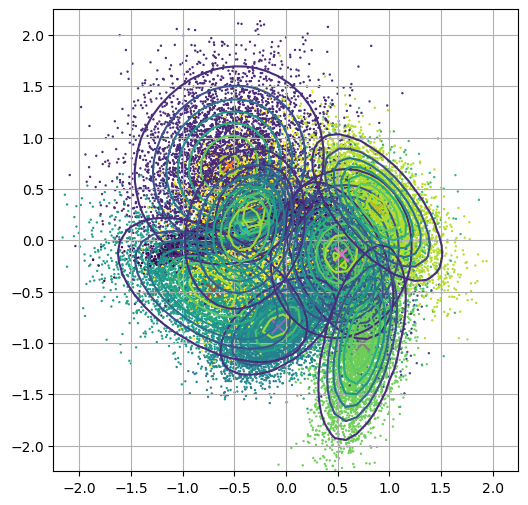

In [489]:
# points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes)

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

In [490]:
points.shape

(50000, 2)

### Variational AutoEncoder - from F Chollet's keras3 doc

In [536]:
# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent variable encoding an input."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # log var plutôt que l'écart type
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # reparametrisation trick from original article Kingma and Welling, “Auto-Encoding Variational Bayes”, ICLR 2014
        scale = 1.0 # tentative de diminuer le bruit pour éviter le posterior collapse... on sample "étroit" ?
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon * scale

In [537]:
input_dim = 2
output_dim = 2
latent_dim = 2

### Encoder

In [538]:
encoder_inputs = keras.Input(shape=(input_dim,))

# basic MLP
x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)

# output mean et log_var de la gaussienne
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# sample de la gaussienne inférée par le MLP
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_175 (Dense)   │ (None, 64)        │        192 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_176 (Dense)   │ (None, 32)        │      2,080 │ dense_175[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_177 (Dense)   │ (None, 16)        │        528 │ dense_176[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_177[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_177[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_25         │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,868 (11.20 KB)

 Trainable params: 2,868 (11.20 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [539]:
# input : vecteur de l'espace latent
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

decoder_outputs = layers.Dense(output_dim)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,834 (11.07 KB)

 Trainable params: 2,834 (11.07 KB)

 Non-trainable params: 0 (0.00 B)

### VAE

In [540]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # encodeur vers l'espace latent
        self.encoder = encoder
        # décodeur depuis l'espace latent
        self.decoder = decoder
        # losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # une étape de forward pass, avec différentiation des losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # forward pass de l'encodeur
            reconstruction = self.decoder(z)  # veceteur reconstruit depuis la variable latent samplée
            # 1ere loss : erreur reconstruction entre la data et la reconstruction
            reconstruction_loss = ops.mean(keras.losses.mean_squared_error(data, reconstruction)),  # norme L2 pour calculer l'erreur de reconstruction
            # 2e loss : KL entre le posterior z|x appris par l'encodeur et N(0,I) cible
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # loss totale (ELBO)
            total_loss = reconstruction_loss + kl_loss
            
        # calcul des gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [541]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

s.fit(points)

x_train = s.transform(points)

In [542]:
# basic training

vae = VAE(encoder, decoder)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
    # mode='min'
)

vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=1000, batch_size=128, callbacks=[callback])

Epoch 1/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - kl_loss: 0.0150 - loss: 1.0025 - reconstruction_loss: 0.9875
Epoch 2/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - kl_loss: 0.0776 - loss: 0.9965 - reconstruction_loss: 0.9189
Epoch 3/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 0.0770 - loss: 0.9903 - reconstruction_loss: 0.9133
Epoch 4/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 0.0851 - loss: 0.9910 - reconstruction_loss: 0.9059
Epoch 5/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - kl_loss: 0.0917 - loss: 0.9975 - reconstruction_loss: 0.9058
Epoch 6/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 0.0866 - loss: 0.9878 - reconstruction_loss: 0.9012
Epoch 7/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - kl_loss: 0.0868 - loss: 0.9873 - reconstruction_loss: 0.9004
Epoch 8/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - kl_loss: 0.0746 - loss: 1.0064 - reconstruction_loss: 0.9317
Epoch 9/1000
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - 

### Display latent space

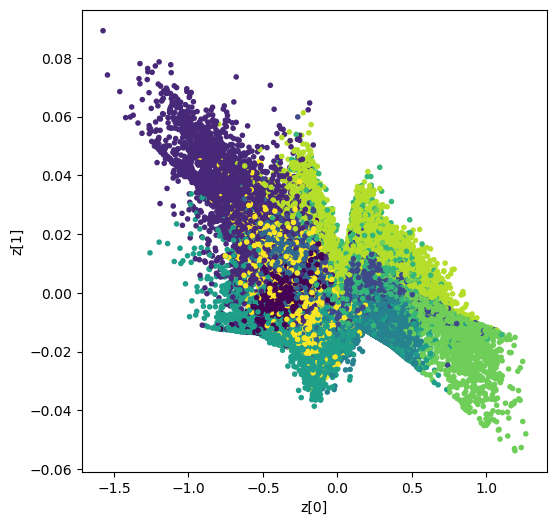

In [543]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the latent space
    z_mean, _, _ = vae.encoder.predict(s.transform(data), verbose=0)
    plt.figure(figsize=(6, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], marker='.', c=labels)
    # plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, points, labels)

In [499]:
N_DISPLAY = 5

points[:N_DISPLAY]

array([[ 0.72829864, -0.36053462],
       [ 0.20035542,  0.12076936],
       [ 0.02543853,  0.27129361],
       [-1.42936771,  0.4547006 ],
       [-0.69674533,  0.74359557]])

In [500]:
z_mean, z_log_var, z = encoder(s.transform(points[:N_DISPLAY]))

In [501]:
z_mean

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-1.9777060e-02, -3.7750936e-01],
       [ 5.4988079e-04,  1.4487138e-02],
       [ 9.7378101e-03,  1.5028888e-01],
       [ 5.2480757e-02,  8.0425268e-01],
       [ 3.8637687e-02,  6.1647844e-01]], dtype=float32)>

In [502]:
z_log_var

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.00581468, -0.1958715 ],
       [-0.00153656, -0.20608878],
       [-0.00470086, -0.20484653],
       [-0.02148651, -0.20921414],
       [-0.01627341, -0.22580874]], dtype=float32)>

In [503]:
z

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.9204216 , -0.21685283],
       [-1.0872644 ,  1.3619566 ],
       [-1.0101004 ,  0.90246606],
       [-0.50645095,  1.2526286 ],
       [-0.00436244, -0.10594875]], dtype=float32)>

In [504]:
decoded = decoder(z)
decoded = s.inverse_transform(decoded)

decoded[:N_DISPLAY]

array([[ 0.07354587, -0.13483616],
       [-0.22261104,  0.08928641],
       [-0.13212641,  0.02229246],
       [-0.21839342,  0.08272622],
       [ 0.04489035, -0.1185788 ]])

In [505]:
points[:N_DISPLAY]

array([[ 0.72829864, -0.36053462],
       [ 0.20035542,  0.12076936],
       [ 0.02543853,  0.27129361],
       [-1.42936771,  0.4547006 ],
       [-0.69674533,  0.74359557]])